In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ncps.tf import LTCCell

In [4]:
df = pd.read_csv('household_power_consumption.csv', sep=',')

In [5]:
def standardize_date_format(date):
    # Try to parse the date using both formats
    try:
        # First, try parsing the date with a two-digit year
        return pd.to_datetime(date, format='%d/%m/%y').strftime('%d/%m/%Y')
    except ValueError:
        # If it fails, try parsing with a four-digit year
        return pd.to_datetime(date, format='%d/%m/%Y').strftime('%d/%m/%Y')

In [6]:
df['Date'] = df['Date'].apply(standardize_date_format)

# Combine 'Date' and 'Time' columns into a single 'Datetime' column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

In [7]:
df.set_index('Datetime', inplace=True)

# Display the first few rows to check the result
print(df.head())


                     index        Date     Time Global_active_power  \
Datetime                                                              
2007-01-01 00:00:00      0  01/01/2007  0:00:00                2.58   
2007-01-01 00:01:00      1  01/01/2007  0:01:00               2.552   
2007-01-01 00:02:00      2  01/01/2007  0:02:00                2.55   
2007-01-01 00:03:00      3  01/01/2007  0:03:00                2.55   
2007-01-01 00:04:00      4  01/01/2007  0:04:00               2.554   

                    Global_reactive_power Voltage Global_intensity  \
Datetime                                                             
2007-01-01 00:00:00                 0.136  241.97             10.6   
2007-01-01 00:01:00                   0.1  241.75             10.4   
2007-01-01 00:02:00                   0.1  241.64             10.4   
2007-01-01 00:03:00                   0.1  241.71             10.4   
2007-01-01 00:04:00                   0.1  241.98             10.4   

           

In [14]:
cols_to_numeric = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
                   'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Resample to hourly frequency and calculate the mean
df_hourly = df[cols_to_numeric].resample('H').mean()

df_hourly = df_hourly.round(4)

# Reset index to get Date and Time separately
df_hourly.reset_index(inplace=True)
df_hourly['Date'] = df_hourly['Datetime'].dt.strftime('%d/%m/%y')
df_hourly['Time'] = df_hourly['Datetime'].dt.strftime('%H:%M:%S')
df_hourly.drop(columns=['Datetime'], inplace=True)

# Reorder the columns
df_hourly = df_hourly[['Date', 'Time'] + cols_to_numeric]

In [15]:
df_hourly.to_csv('processed_hourly_data.csv', index=False)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
import ncps
from ncps.tf import LTCCell
from tensorflow.keras.layers import RNN

In [3]:
df = pd.read_csv('processed_hourly_data.csv')

# Features and target
X = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 
        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].values
y = df['Global_active_power'].values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be 3D [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [4]:
from ncps.wirings import FullyConnected

In [6]:
# from ncps.wirings import AutoNCP
# from ncps.tf import LTC
# import tensorflow as tf
# height, width, channels = (78, 200, 3)

# ncp = LTC(AutoNCP(32, output_size=8), return_sequences=True)

# model = tf.keras.models.Sequential(
#     [
#         tf.keras.layers.InputLayer(input_shape=(None, height, width, channels)),
#         tf.keras.layers.TimeDistributed(
#             tf.keras.layers.Conv2D(32, (5, 5), activation="relu")
#         ),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D()),
#         tf.keras.layers.TimeDistributed(
#             tf.keras.layers.Conv2D(64, (5, 5), activation="relu")
#         ),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D()),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
#         tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation="relu")),
#         ncp,
#         tf.keras.layers.TimeDistributed(tf.keras.layers.Activation("softmax")),
#     ]
# )
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.01),
#     loss='sparse_categorical_crossentropy',
# )

from ncps.wirings import AutoNCP
from ncps.tf import LTCCell
import tensorflow as tf

# Define the wiring and the LTC cell
wiring = AutoNCP(32, output_size=1)  # 32 hidden units, output size 1
ltc_cell = LTCCell(wiring)

# Build the Sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1, X_train.shape[2])),  # Input shape (time steps, features)
    tf.keras.layers.RNN(ltc_cell, return_sequences=False),  # LTC layer
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50

87/87 [==============================] - 17s 28ms/step - loss: nan - val_loss: nan
Epoch 2/50
87/87 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 3/50
87/87 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 4/50
87/87 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 5/50
87/87 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 6/50
87/87 [==============================] - 1s 11ms/step - loss: nan - val_loss: nan
Epoch 7/50
87/87 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 8/50
87/87 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 9/50
87/87 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 10/50
87/87 [==============================] - 1s 12ms/step - loss: nan - val_loss: nan
Epoch 11/50
87/87 [==============================] - 1s 12ms/step -

KeyboardInterrupt: 

In [9]:
# wiring = FullyConnected(units=32)  # You can adjust the number of units based on your needs

# # Create the LTCCell with the wiring
# ltc_cell = LTCCell(wiring=wiring)

# # Define the model
# model = Sequential()

# # Add an input layer
# model.add(Input(shape=(1, X_train.shape[2])))

# # Add the LTC RNN layer
# model.add(RNN(ltc_cell, return_sequences=False))

# # Add a dense output layer
# model.add(Dense(1))

# # Compile the model
# from tensorflow.keras.optimizers import Adam
# optimizer = Adam(clipvalue=1.0)
# model.compile(optimizer=optimizer, loss='mse')

In [5]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\sriva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, None, 78, 200, 3), found shape=(None, 1, 6)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN
from ncps.tf import LTCCell
from ncps.wirings import FullyConnected
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('processed_hourly_data.csv')

# Display the first few rows
print(df.head())

print(df.isnull().sum())

# Drop rows with missing values if any
#df = df.dropna()

#first method of dropping gave a considerably low mean. We shall now use the second method of replacing the null values with the mean of that column

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

       Date      Time  Global_active_power  Global_reactive_power   Voltage  \
0  01/01/07  00:00:00               2.5506                 0.1128  241.3613   
1  01/01/07  01:00:00               2.5234                 0.0716  241.0965   
2  01/01/07  02:00:00               2.5823                 0.1067  243.2002   
3  01/01/07  03:00:00               2.5417                 0.0901  243.2657   
4  01/01/07  04:00:00               2.4757                 0.0882  242.4562   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0           10.5300             0.0          0.5833             0.0  
1           10.4433             0.0          0.0000             0.0  
2           10.5400             0.0          0.3333             0.0  
3           10.4000             0.0          0.2667             0.0  
4           10.1100             0.0          0.0000             0.0  
Date                      0
Time                      0
Global_active_power      61
Global_reactive_power

In [4]:
TIME_STEPS = 24  # Using past 24 hours to predict the next hour

# Select features and target
features = ['Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
target = 'Global_active_power'

# Scaling features
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on the data
df[features] = feature_scaler.fit_transform(df[features])
df[target] = target_scaler.fit_transform(df[[target]])

In [5]:
def create_sequences(df, features, target, time_steps=TIME_STEPS):
    X = []
    y = []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(df, features, target)

print(f'Shape of X: {X.shape}')  # Expected: (samples, TIME_STEPS, features)
print(f'Shape of y: {y.shape}')  # Expected: (samples,)

Shape of X: (4320, 24, 6)
Shape of y: (4320,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffling for time series data
)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: (3456, 24, 6)
Testing set shape: (864, 24, 6)


In [7]:
from ncps.wirings import AutoNCP
wiring = AutoNCP(16,1)
ltc_cell = LTCCell(wiring)

# Build the model
model = Sequential([
    RNN(ltc_cell, input_shape=(TIME_STEPS, len(features))),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 1)                 1470      
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 1472 (5.75 KB)
Trainable params: 1472 (5.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200


108/108 [==============================] - 16s 40ms/step - loss: 0.0365 - mae: 0.1553 - val_loss: 0.0191 - val_mae: 0.1197
Epoch 2/200
108/108 [==============================] - 4s 34ms/step - loss: 0.0261 - mae: 0.1298 - val_loss: 0.0187 - val_mae: 0.1194
Epoch 3/200
108/108 [==============================] - 4s 33ms/step - loss: 0.0196 - mae: 0.1071 - val_loss: 0.0122 - val_mae: 0.0883
Epoch 4/200
108/108 [==============================] - 3s 32ms/step - loss: 0.0140 - mae: 0.0850 - val_loss: 0.0105 - val_mae: 0.0795
Epoch 5/200
108/108 [==============================] - 3s 32ms/step - loss: 0.0127 - mae: 0.0803 - val_loss: 0.0097 - val_mae: 0.0751
Epoch 6/200
108/108 [==============================] - 3s 32ms/step - loss: 0.0122 - mae: 0.0781 - val_loss: 0.0104 - val_mae: 0.0812
Epoch 7/200
108/108 [==============================] - 3s 32ms/step - loss: 0.0122 - mae: 0.0785 - val_loss: 0.0095 - val_mae: 0.0721
Epoch 8/200
108/108 [==============================] - 4s 3

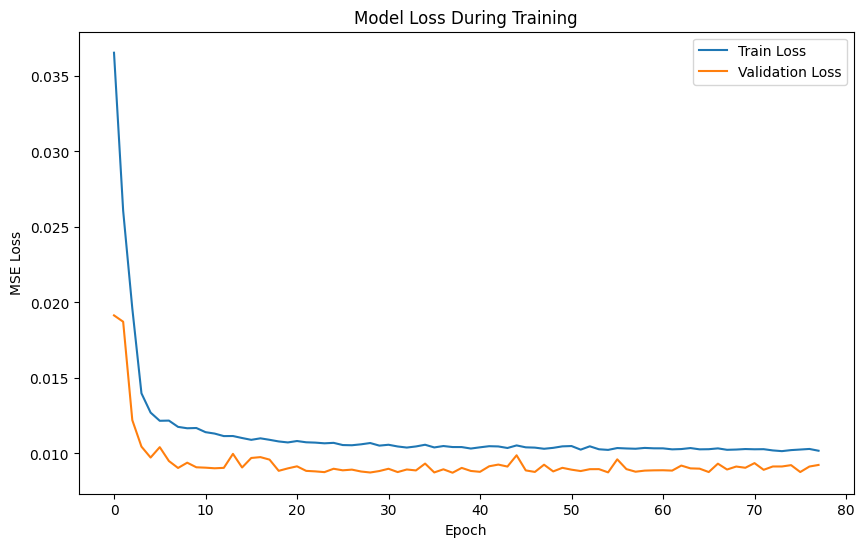

In [9]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MSE: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

27/27 [==============================] - 0s 9ms/step - loss: 0.0087 - mae: 0.0632
Test MSE: 0.0087
Test MAE: 0.0632


In [11]:
# y_pred = model.predict(X_test)

# # Inverse transform predictions and actual values
# y_pred_inv = target_scaler.inverse_transform(y_pred)
# y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
import time

# Measure the start time
start_time = time.time()

# Make predictions
y_pred = model.predict(X_test)

# Measure the end time
end_time = time.time()

# Calculate the elapsed time
prediction_time = end_time - start_time
print(f"Time taken for prediction: {prediction_time} seconds")

# Inverse transform predictions and actual values
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

27/27 [==============================] - 1s 9ms/step
Time taken for prediction: 0.8420522212982178 seconds


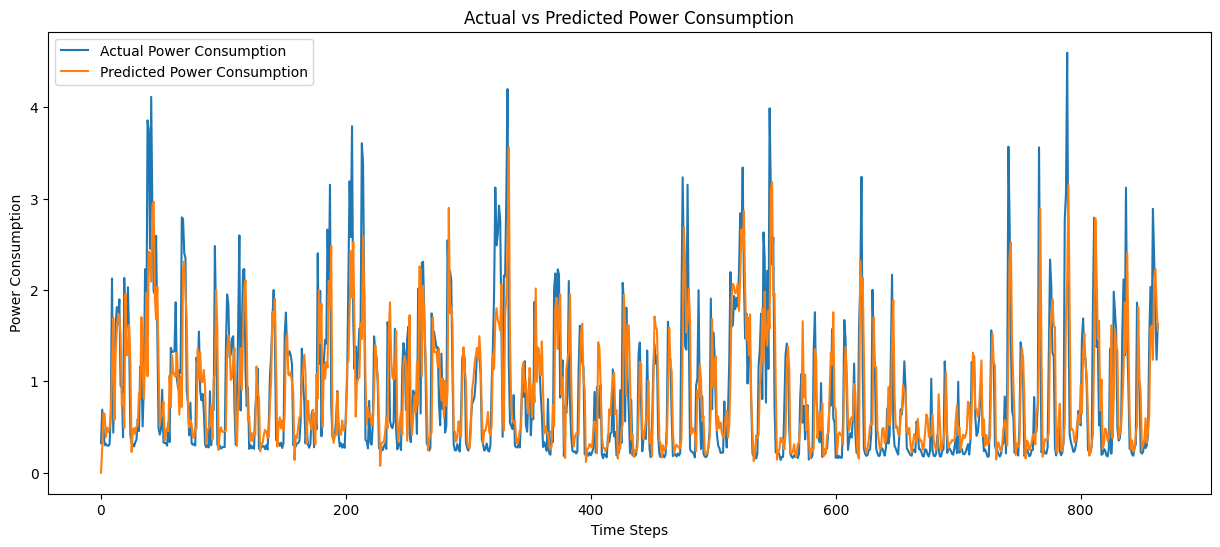

In [12]:
plt.figure(figsize=(15,6))
plt.plot(y_test_inv, label='Actual Power Consumption')
plt.plot(y_pred_inv, label='Predicted Power Consumption')
plt.title('Actual vs Predicted Power Consumption')
plt.xlabel('Time Steps')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

In [12]:
#model.save('lnn_power_consumption_model.h5')
model.save_weights('lnn_power_consumption_weightsV2.h5')

In [5]:
loaded_model = tf.keras.models.load_model('lnn_power_consumption_model.h5', custom_objects={'LTCCell': LTCCell})

KeyError: 'adjacency_matrix'

In [15]:
def mean_bias_deviation(y_true, y_pred):
    return np.mean(y_pred - y_true)
y_pred = model.predict(X_test)

# Calculate MAE, MSE, MBD, and R²
mae = tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy()
mse = tf.keras.metrics.mean_squared_error(y_test, y_pred).numpy()
mbd = mean_bias_deviation(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Print the results
#print(f"Mean Absolute Error (MAE): {mae}")
#print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Bias Deviation (MBD): {mbd}")
print(f"R-squared (R²): {r_squared}")

27/27 [==============================] - 0s 9ms/step
Mean Bias Deviation (MBD): 0.004834602294126144
R-squared (R²): 0.3955848670935246
